In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
import json
from webdriver_manager.chrome import ChromeDriverManager
from pandas.io.json import json_normalize
import pandas as pd

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pandas import json_normalize


from adjustText import adjust_text
from matplotlib import cm
import matplotlib.patheffects as path_effects

In [3]:
driver = webdriver.Chrome(ChromeDriverManager().install())

driver.get('https://www.whoscored.com/Matches/1485194/Live/England-Premier-League-2020-2021-Arsenal-West-Ham')
data = driver.execute_script("return matchCentreData;")

with open('data.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)
       
driver.close()

[WDM] - Current google-chrome version is 85.0.4183
[WDM] - Get LATEST driver version for 85.0.4183
[WDM] - Get LATEST driver version for 85.0.4183
[WDM] - Trying to download new driver from http://chromedriver.storage.googleapis.com/85.0.4183.87/chromedriver_mac64.zip


[WDM] - Driver has been saved in cache [/Users/ollinj01/.wdm/drivers/chromedriver/mac64/85.0.4183.87]


In [7]:
home_team, away_team = data["home"]["name"], data["away"]["name"]
with open(f"{home_team}_{away_team}.json", "w") as f: ## save as Arsenal_Liverpool.json in present directory
    json.dump(data, f, indent=4)

In [4]:
class Player:

    def __init__(self, name, pid, x, y, total):
        self.name = name
        self.pid = pid
        self.x = x
        self.y = y
        self.total = total

In [5]:
def get_receiver(df):
    """ Get the receiver for successful open-play passes"""

    df[["receiver_id", "receiver_team_id"]] = df[["playerId", "teamId"]].shift(-1)
    df = df.query("(outcomeType_value == 1) & (type_displayName == 'Pass') & (receiver_team_id == teamId)").reset_index(drop=True)
    df.dropna(subset=["playerId", "receiver_id", "teamId", "receiver_team_id"], inplace=True)
    df[["playerId", "receiver_id", "teamId", "receiver_team_id"]] = df[["playerId", "receiver_id", "teamId", "receiver_team_id"]].astype(int)
    return df

In [8]:
with open(r"Arsenal_West Ham.json") as f:
    md = json.load(f)

In [9]:
side = "home" if md["home"]["name"] == "Arsenal" else "away"  
team_id = md[side]["teamId"]  
st_players = {} ##get the starting 11 players
for player in md[side]["players"]:
        if "isFirstEleven" in player:
            st_players.update({player["playerId"]: player["name"]})        


In [10]:
df = json_normalize(md["events"], sep="_")

In [11]:
pdf = get_receiver(df)

In [12]:
pdf = pdf[pdf["qualifiers"].apply(lambda x:x not in ["Freekick", "GoalKick", "Corner"])] ##remove set-pieces

In [13]:
pdf = pdf.dropna(axis=1, how="all")

In [14]:
group1 = pdf.groupby(["playerId", "receiver_id"]).agg(count=("teamId", "size")).reset_index()

In [15]:
group1 = group1.loc[group1["count"]>1]

In [16]:
group1["count"] = group1["count"]/group1["count"].max()

In [17]:
group2 = pdf.groupby(["playerId"]).agg(x=("x", "mean"), y=("y", "mean"), total=("teamId", "size")).reset_index()

In [18]:
group2['x_loc_m'] = group2['x'] / 100 * 104
group2['y_loc_m'] = group2['y'] / 100 * 68

In [19]:
group2['y1'] = [68 - i for i in group2['y_loc_m']] # Note y axis is flipped for vertical pitch view

In [20]:
stplist = list(st_players.keys()) ##list of starting players ids

In [21]:
group1 = group1.query("(playerId in @stplist) & (receiver_id in @stplist)").reset_index(drop=True)

In [22]:
group2 = group2.query("playerId in @stplist").reset_index(drop=True)

In [23]:
group2["player_name"] = group2["playerId"].map(st_players)

In [24]:
%matplotlib inline

In [25]:
plr_objs = {}
for i in group2.index:
    plr_objs[group2.loc[i, "playerId"]] = Player(group2.loc[i, "player_name"], group2.loc[i, "playerId"], group2.loc[i, "y1"], group2.loc[i, "x_loc_m"], group2.loc[i, "total"])

In [49]:
group1

,playerId,receiver_id,count
0,29463,73078,0.291667
1,29463,89401,0.250000
2,29463,110260,0.083333
3,29463,125211,0.125000
4,29463,144890,0.458333
...,...,...,...
73,367185,44120,0.166667
74,367185,89401,0.250000
75,367185,110260,0.333333
76,367185,144890,0.208333


In [27]:
import matplotlib.colors

In [28]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [29]:
cmap = ListedColormap(["white","gainsboro","lightgrey","silver","darkgray","gray","dimgray"])

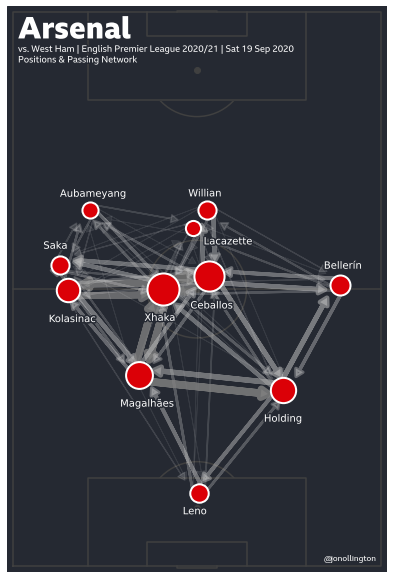

In [54]:
draw_pitch(pitch ='#252932', line ='#404040',orientation='vertical', view='full')

csfont = {'fontname':'BBC Reith Sans'}
hfont = {'fontname':'BBC Reith Sans'}

offset = 1.1 ##change the x and y coordinates of passes between two same players so that there's no overlap

# cmap = cm.get_cmap("Greys")
cmap = ListedColormap(["white","gainsboro","lightgrey","silver","darkgray","gray","dimgray"])

shrink_val = 5 ##Units by which the arrow is shortened from the end_points

style="Simple,tail_width=0.001,head_width=0.8,head_length=0.7"

plr_objs = {}
for i in group2.index:
    plr_objs[group2.loc[i, "playerId"]] = Player(group2.loc[i, "player_name"], group2.loc[i, "playerId"], group2.loc[i, "y1"], group2.loc[i, "x_loc_m"], group2.loc[i, "total"])

for (_, (pid, rid, count)) in group1.iterrows():
    if abs(plr_objs[rid].x - plr_objs[pid].x) > abs(plr_objs[rid].y - plr_objs[pid].y):
        if rid > pid:
            plt.annotate("", xy=(plr_objs[rid].x, plr_objs[rid].y + offset), xytext=(plr_objs[pid].x, plr_objs[pid].y + offset),
                arrowprops={"arrowstyle":style, "connectionstyle":"arc3", "lw":count*9,"color":cmap(count), "alpha":count, "linestyle":"solid", "shrinkB":15},zorder=9)
        elif pid > rid:
            plt.annotate("", xy=(plr_objs[rid].x, plr_objs[rid].y - offset), xytext=(plr_objs[pid].x, plr_objs[pid].y - offset),
                arrowprops={"arrowstyle":style, "connectionstyle":"arc3", "lw":count*9,"color":cmap(count), "alpha":count, "linestyle":"solid", "shrinkB":15},zorder=9)
    
    elif abs(plr_objs[rid].x - plr_objs[pid].x) <= abs(plr_objs[rid].y - plr_objs[pid].y):
        if rid > pid:
            plt.annotate("", xy=(plr_objs[rid].x + offset, plr_objs[rid].y), xytext=(plr_objs[pid].x + offset, plr_objs[pid].y),
                arrowprops={"arrowstyle":style, "connectionstyle":"arc3", "lw":count*9, "color":cmap(count),"alpha":count, "linestyle":"solid", "shrinkB":15},zorder=9)
        elif pid > rid:
            plt.annotate("", xy=(plr_objs[rid].x - offset, plr_objs[rid].y), xytext=(plr_objs[pid].x - offset, plr_objs[pid].y),
                arrowprops={"arrowstyle":style, "connectionstyle":"arc3", "lw":count*9, "color":cmap(count),"alpha":count, "linestyle":"solid", "shrinkB":15},zorder=9)

texts = []        
for player_id, player_obj in plr_objs.items():
    plt.scatter(player_obj.x, player_obj.y, s=player_obj.total*10, color="#DB0007", ec="white", lw="2",alpha=1, zorder=10)
    if player_obj.name == "Pierre-Emerick Aubameyang":
        t1 = plt.text(player_obj.x-5.5,player_obj.y+2.5,color="white", s=player_obj.name.split(" ")[-1], fontsize=10, rotation=0, zorder=12)
        t1.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj.name == "Alexandre Lacazette":
        t2 = plt.text(player_obj.x+2,player_obj.y-3,color="white", s=player_obj.name.split(" ")[-1], fontsize=10, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj.name == "Willian":
        t2 = plt.text(player_obj.x-3.5,player_obj.y+2.5,color="white", s=player_obj.name.split(" ")[-1], fontsize=10, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj.name == "Héctor Bellerín":
        t2 = plt.text(player_obj.x-3,player_obj.y+3,color="white", s=player_obj.name.split(" ")[-1], fontsize=10, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj.name == "Bukayo Saka":
        t2 = plt.text(player_obj.x-3,player_obj.y+3,color="white", s=player_obj.name.split(" ")[-1], fontsize=10, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    elif player_obj.name == "Bernd Leno":
        t2 = plt.text(player_obj.x-3,player_obj.y-4,color="white", s=player_obj.name.split(" ")[-1], fontsize=10, rotation=0, zorder=12)
        t2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    else:
        t = plt.text(player_obj.x-3.5, player_obj.y-6,color="white", s=player_obj.name.split(" ")[-1], fontsize=10, rotation=0, zorder=12)
        t.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
    
    
#title
title = plt.text(1,99, "Arsenal", color='white',fontsize=30, fontweight='bold', **csfont,zorder=20)
title.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
subtitle_string = 'vs. West Ham | English Premier League 2020/21 | Sat 19 Sep 2020'
subtitle_string2 = 'Positions & Passing Network'
subtitle = plt.text(1, 96.5, subtitle_string, fontsize=9,**csfont, color='white',zorder=20)
subtitle.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])
subtitle2 = plt.text(1, 94.5, subtitle_string2, fontsize=9,**csfont, color='white',zorder=20)
subtitle2.set_path_effects([path_effects.withStroke(linewidth=3,foreground="#252932")])

plt.figimage(img, 1430, 2182, alpha=.9, zorder=1)

info_string = '@jonollington'
plt.text(57.3, 0.8, info_string, color='white', ha='left', va='bottom', fontsize=8, **csfont)

plt.rcParams['axes.facecolor']='#252932'
plt.rcParams['savefig.facecolor']='#252932'

plt.savefig("arsenal_westham",bbox_inches="tight",dpi=300)

In [31]:
def draw_pitch(pitch, line, orientation, view):
     
    orientation = orientation
    view = view
    line = line
    pitch = pitch
     
    if orientation.lower().startswith("h"):
         
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(49,105)
            plt.ylim(-1,69)
        elif view.lower().startswith("t"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(69,105)
            plt.ylim(-1,69)
            # final third line
            lxt = [0,68] 
            lyt = [69,69]
            plt.plot(lxt,lyt,color=line,linestyle='--',zorder=5)
        else:
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.xlim(-1,105)
            plt.ylim(-1,69)
        ax.axis('off') # this hides the x and y ticks
     
        # side and goal lines #
        ly1 = [0,0,68,68,0]
        lx1 = [0,104,104,0,0]
 
        plt.plot(lx1,ly1,color=line,zorder=5)
 
 
        # boxes, 6 yard box and goals
 
            #outer boxes#
        ly2 = [13.84,13.84,54.16,54.16] 
        lx2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)
 
        ly3 = [13.84,13.84,54.16,54.16] 
        lx3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)
 
            #goals#
        ly4 = [30.34,30.34,37.66,37.66]
        lx4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)
 
        ly5 = [30.34,30.34,37.66,37.66]
        lx5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)
 
 
           #6 yard boxes#
        ly6 = [24.84,24.84,43.16,43.16]
        lx6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)
 
        ly7 = [24.84,24.84,43.16,43.16]
        lx7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)
 
        #Halfway line, penalty spots, and kickoff spot
        ly8 = [0,68] 
        lx8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)
 
 
        plt.scatter(93,34,color=line,zorder=5)
        plt.scatter(11,34,color=line,zorder=5)
        plt.scatter(52,34,color=line,zorder=5)
 
        circle1 = plt.Circle((93.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((10.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)
 
        ## Rectangles in boxes
        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-',color=pitch, zorder=1,alpha=1)
 
        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color=pitch, zorder=1,alpha=1)
 
        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
         
    else:
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(49,105)
            plt.xlim(-1,69)
        elif view.lower().startswith("t"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(69,105)
            plt.xlim(-1,69)
            # final third line
            lxt = [0,68] 
            lyt = [69,69]
            plt.plot(lxt,lyt,color=line,linestyle='--',zorder=5)
        else:
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.ylim(-1,105)
            plt.xlim(-1,69)
        ax.axis('off') # this hides the x and y ticks
 
        # side and goal lines #
        lx1 = [0,0,68,68,0]
        ly1 = [0,104,104,0,0]
 
        plt.plot(lx1,ly1,color=line,zorder=5)
 
 
        # boxes, 6 yard box and goals
 
            #outer boxes#
        lx2 = [13.84,13.84,54.16,54.16] 
        ly2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)
 
        lx3 = [13.84,13.84,54.16,54.16] 
        ly3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)
 
            #goals#
        lx4 = [30.34,30.34,37.66,37.66]
        ly4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)
 
        lx5 = [30.34,30.34,37.66,37.66]
        ly5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)
 
 
           #6 yard boxes#
        lx6 = [24.84,24.84,43.16,43.16]
        ly6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)
 
        lx7 = [24.84,24.84,43.16,43.16]
        ly7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)
 
        #Halfway line, penalty spots, and kickoff spot
        lx8 = [0,68] 
        ly8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)
 
 
        plt.scatter(34,93,color=line,zorder=5)
        plt.scatter(34,11,color=line,zorder=5)
        plt.scatter(34,52,color=line,zorder=5)
 
        circle1 = plt.Circle((34,93.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((34,10.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((34,52), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)
 
 
        ## Rectangles in boxes
        rec1 = plt.Rectangle((20, 87.5), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((20, 0), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
 
        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 70,106,ls='-',color=pitch, zorder=1,alpha=1)
 
        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        return

In [32]:
from PIL import Image

In [33]:
img = Image.open('./arsenal.png')
img.size

(411, 481)

In [34]:
img = img.resize((144, 168), Image.ANTIALIAS)

In [53]:
group2

,playerId,x,y,total,x_loc_m,y_loc_m,y1,player_name
0,29463,64.315152,47.203030,33,66.887758,32.098061,35.901939,Willian
1,44120,64.253846,79.073077,26,66.824000,53.769692,14.230308,Pierre-Emerick Aubameyang
2,73078,60.947826,51.113043,23,63.385739,34.756870,33.243130,Alexandre Lacazette
3,89401,50.058252,59.118447,103,52.060583,40.200544,27.799456,Granit Xhaka
4,92173,13.261765,49.426471,34,13.792235,33.610000,34.390000,Bernd Leno
5,110260,49.836364,85.054545,55,51.829818,57.837091,10.162909,Sead Kolasinac
6,125211,50.797500,11.150000,40,52.829400,7.582000,60.418000,Héctor Bellerín
7,144890,52.281319,46.629670,91,54.372571,31.708176,36.291824,Dani Ceballos
8,288795,31.876563,26.679687,64,33.151625,18.142187,49.857813,Rob Holding
9,334087,34.587500,65.684722,72,35.971000,44.665611,23.334389,Gabriel Magalhães
